In [24]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [25]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [28]:
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True)
classifier = classifier.cuda()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet44-2a3cabcb.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet44-2a3cabcb.pt


  0%|          | 0.00/2.62M [00:00<?, ?B/s]

In [29]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [30]:
accuracy(classifier)

Accuracy: 91.31 %


In [31]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(3, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 118),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [40]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(128, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=2), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,3,5, stride=1, padding=2), 
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [51]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels) + 100 * torch.linalg.norm(perturbation, ord=1, dim=1).mean(), perturbation

In [52]:
epsilon = 0.04
epochs = 20
model = Generator(epsilon).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)

for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [1/391], Loss: 302.6040344238281
Epoch [1/20], Step [101/391], Loss: 28.546640396118164
Epoch [1/20], Step [201/391], Loss: 19.931814193725586
Epoch [1/20], Step [301/391], Loss: 16.992393493652344
Epoch [2/20], Step [1/391], Loss: 14.65959358215332
Epoch [2/20], Step [101/391], Loss: 13.606132507324219
Epoch [2/20], Step [201/391], Loss: 12.392830848693848
Epoch [2/20], Step [301/391], Loss: 12.480157852172852
Epoch [3/20], Step [1/391], Loss: 11.865779876708984
Epoch [3/20], Step [101/391], Loss: 12.50036907196045
Epoch [3/20], Step [201/391], Loss: 11.367286682128906
Epoch [3/20], Step [301/391], Loss: 11.261022567749023
Epoch [4/20], Step [1/391], Loss: 11.808334350585938
Epoch [4/20], Step [101/391], Loss: 11.348699569702148
Epoch [4/20], Step [201/391], Loss: 10.592353820800781
Epoch [4/20], Step [301/391], Loss: 11.300752639770508
Epoch [5/20], Step [1/391], Loss: 10.53512191772461
Epoch [5/20], Step [101/391], Loss: 11.773183822631836
Epoch [5/20], Step [201/

In [55]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(torch.clamp(model.loss(images, labels, gen_labels)[1], min=-0.04, max=0.04) + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [56]:
adv_accuracy(classifier)

Adversarial accuracy: 79.21 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.31647798
0.49666122
0.19449857
0.28192133
0.4428666
0.24220435
0.4481047
0.37321752
0.27584687
0.25248262
0.24016248
0.37720004
0.26957625
0.41544238
0.5582609
0.4507989
0.27516618
0.3614901
0.41134247
0.4133721
0.4499338
0.86351764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.23026182
0.4971228
0.3415181
0.2880738
0.36379763
0.35650384
0.42070696
0.3754583
0.38433647
0.22923341
0.32896006
0.2888601
0.3574326
0.33016562
0.24182357
0.38166118
0.39996442
0.25592235
0.37904596
0.45513108
0.25385538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.24737148
0.6334003
0.26020238
0.25839278
0.3706258
0.35950845
0.36402503
0.32949886
0.3295912
0.43270853
0.3564522
0.29454353
0.2952694
0.34193316
0.4293684
0.24556161
0.34539026
0.39887428
0.27673295
0.33353254
0.30203083


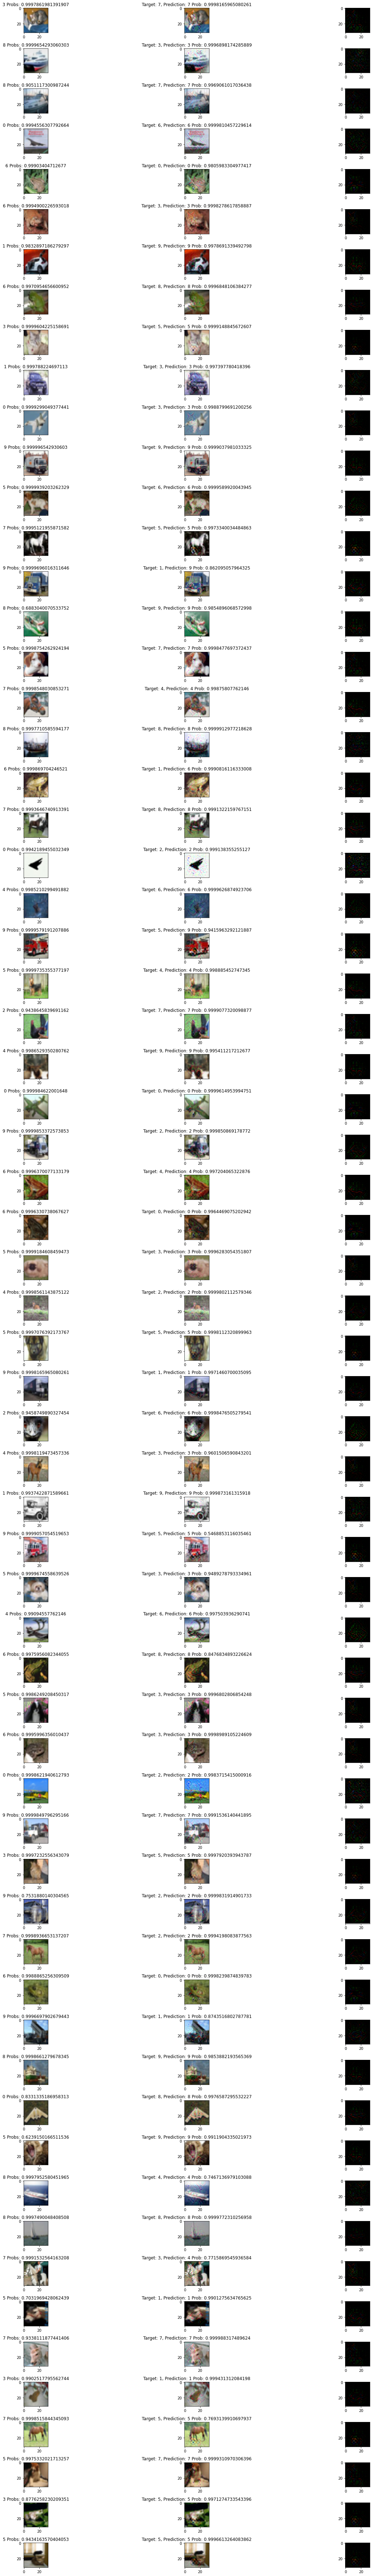

In [50]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = F.softmax(classifier(x+perturbations), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation, cmap='gray'))
          print(perturbation.max())
  break

plt.tight_layout()
plt.show()